# Imports

In [1]:
# Standard library imports
import random

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.special import comb
from scipy.optimize import fsolve

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Custom colormaps
sunset = [
    "#a50026", "#d73027", "#f46d43", "#fdae61", "#fee090", "#e0f3f8", "#abd9e9", "#74add1", "#4575b4", "#313695"
]

ptog = [
    "#40004b", "#762a83", "#9970ab", "#c2a5cf", "#e7d4e8",
    "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837", "#00441b"
]

# General definitions

In [4]:
def compute_Pm(J):
    N = J.shape[0]
    dp = torch.zeros(2 * N + 1, dtype=J.dtype, device=J.device)
    dp[N] = 1.0
    m_vector = torch.arange(-N, N + 1, dtype=J.dtype, device=J.device)
    for l in range(N):
        new_dp = torch.zeros_like(dp)
        up = torch.sigmoid(2 * J[l] * m_vector[:-1])
        new_dp[1:] += dp[:-1] * up
        down = 1 - torch.sigmoid(2 * J[l] * m_vector[1:])
        new_dp[:-1] += dp[1:] * down
        dp = new_dp
    return dp.to(device)

In [5]:
import torch

def transition_matrix_global(probMADE, beta, N):
    device = probMADE.device
    M = len(probMADE)  # M should be N/2 + 1
    
    # Compute m values and their squares: m_i = 2*i/N, with m_max = 1
    m_vals = torch.arange(M, dtype=torch.float64, device=device) * (2.0 / N)
    m2 = m_vals ** 2

    # Precompute the configuration counts (degeneracies) using lgamma for a vectorized comb
    # For i=0: config[0] = comb(N, N//2), and for i>0: config[i] = 2 * comb(N, (N//2) + i)
    indices = torch.arange(M, dtype=torch.float64, device=device)
    k = (N // 2) + indices  # k-values: starting from N//2
    N_tensor = torch.tensor(N, dtype=torch.float64, device=device)
    comb_k = torch.exp(torch.lgamma(N_tensor + 1) - torch.lgamma(k + 1) - torch.lgamma(N_tensor - k + 1))
    config = comb_k.clone()
    if M > 1:
        config[1:] = 2 * config[1:]
    
    # Compute the exponent matrix for all (i, j)
    # exponent[i,j] = 0.5 * beta * N * (m_vals[j]^2 - m_vals[i]^2)
    exponent_matrix = 0.5 * beta * N * (m2[None, :] - m2[:, None])
    exp_matrix = torch.exp(exponent_matrix)
    
    # Compute the ratio matrix (for all i, j):
    # ratio[i,j] = exp_matrix[i,j] * (probMADE[i]*config[j])/(probMADE[j]*config[i])
    ratio = exp_matrix * ((probMADE[:, None] * config[None, :]) / (probMADE[None, :] * config[:, None]))
    
    # Apply the min operation elementwise to get alpha: alpha[i,j] = min(1, ratio[i,j])
    ones = torch.ones_like(ratio)
    alpha = torch.minimum(ones, ratio)
    
    # Off-diagonals: set T[i,j] = probMADE[j] * alpha[i,j]
    T = probMADE[None, :] * alpha
    
    # Exclude the diagonal from the sum and then define T[i,i] = 1 - sum_{j != i} T[i,j]
    # First, zero out the diagonal values in T (they are not used in the off-diagonal sum)
    T.fill_diagonal_(0)
    diag = 1 - T.sum(dim=1)
    T.diagonal(dim1=0, dim2=1).copy_(diag)
    
    return T


# transition matrix for the Markov chain
def transition_matrix_local(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    M = int(N / 2) + 1
    P = torch.zeros((M, M), device=device, dtype=torch.float64)

    m_vals = torch.arange(M, dtype=torch.float64, device=device) * (2.0 / N)

    for i in range(M):
        m = m_vals[i]
        if i == 0:
            P[i, 1] = 1.0
        else:
            P[i, i - 1] = (1 + torch.abs(m)) / 2 * torch.exp(-2 * beta * (torch.abs(m) - 1 / N))
            P[i, i] = 1 - (1 + torch.abs(m)) / 2 * torch.exp(-2 * beta * (torch.abs(m) - 1 / N)) - (1 - torch.abs(m)) / 2
            if i != M - 1:
                P[i, i + 1] = (1 - torch.abs(m)) / 2

    return P

In [6]:
def compute_Pm_abs(N, W):
    Neff = int(N/2)
    probMADE = compute_Pm(torch.tensor(W).to(device))[::2]
    x = probMADE[Neff:]
    x[1:] += torch.flip(probMADE[:Neff], dims=[0])
    probMADE = x
    return probMADE

def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = torch.matmul(Tmade, torch.matrix_power(Tlocal, N * k).to(device))
    return T

In [7]:
def mhat(beta):
    """
    Solves the equation m = tanh(beta * m) for m as a function of beta.

    Parameters:
    - beta (float): The value of beta.

    Returns:
    - float: The solution for m.
    """
    # Define the self-consistent equation
    def self_consistent_eq(m):
        return m - np.tanh(beta * m)
    
    # Initial guess for m
    m_initial = 0.5
    
    # Solve the equation using fsolve
    m_solution = fsolve(self_consistent_eq, m_initial)
    
    return m_solution[0]

In [8]:
def setup_model(W, N = 100):
    model = made(N)
    weights = model.layer.weight.detach()

    # Update each row i of the weight matrix with W[i]
    for i in range(weights.shape[0]):
        weights[i, :] = W[i]

    # Set the upper triangular part of the matrix to 0
    weights = np.tril(weights, -1)  # Keep only the lower triangular part

    # Set the updated weights back to the model
    model.layer.weight.data = torch.tensor(weights)
    model = model.cuda()
    return model

In [9]:
class AutoregressiveMasking(object):
    """Autoregressive constraint for weight matrices."""
    def __init__(self, frequency=1):
        """
        Constructor for AutoregressiveMasking.

        Parameters:
        - frequency (int): Controls how often the autoregressive constraint is applied.
        """
        self.frequency = frequency

    def __call__(self, module):
        """
        Applies the autoregressive constraint to the weight matrices of a module.

        Parameters:
        - module: PyTorch module to which the constraint is applied.
        """
        # Apply autoregressive constraint to weight matrices
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.tril(w, -1)  # Apply lower triangular masking
            module.weight.data = w

# Build the autoregressive model
class made(nn.Module):
    """Autoregressive MADE (Masked Autoencoder for Distribution Estimation)."""
    def __init__(self, input_size):
        """
        Constructor for the MADE model.

        Parameters:
        - input_size (int): Size of the input features.
        """
        super(made, self).__init__()
        self.layer = nn.Linear(input_size, input_size, bias=False)
        # self.constraint = AutoregressiveConstraint()  # Commented out, not used in forward pass
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the MADE model.

        Parameters:
        - x: Input tensor to the model.

        Returns:
        - x: Output tensor after the forward pass.
        """
        x = self.layer(x)
        # x = self.constraint(x)  # Commented out, not used in the forward pass
        x = self.activation(2 * x)  # Apply activation function
        if device == "cuda":
            torch.cuda.empty_cache()  # Clear GPU cache
        return x
    
    def forward_n(self, input, n):
        # Get the n-th row of the weight matrix of the linear layer
        nth_row = self.layer.weight[n]
        x = torch.einsum("ij, j->i", input[:, :n], nth_row[:n])
        x = self.activation(2 * x)
        return x

In [10]:
def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

In [11]:
# Expression of the behaviour of the J(t) i the linearized regime
def Jt_app(t, c, ell, eta):
    def tau_l(c, ell):
        return 1 / (1 + c * (ell - 2))/(ell-1)
    tau = tau_l(c, ell)
    return c*tau*(ell-1)*(1-torch.exp(-eta*t/tau))

In [ ]:
def weights_analytical(t, c, N):
    """
    Computes a tensor of weights based on the Jt_app function.
    
    Parameters:
        t (torch.Tensor): Input tensor (e.g., time values).
        c (float or torch.Tensor): A scaling parameter.
        N (int): Maximum ell value (ell runs from 2 to N inclusive).
        
    Returns:
        torch.Tensor: A tensor with shape (len(t), N) where:
            - The first column (ell=1) is all zeros.
            - Columns 2 to N contain Jt_app(t, c, ell, 1/(N*(ell-1))) for ell=2,...,N.
    """
    weights = []
    # Add the column corresponding to ell = 1 (all zeros).
    zeros = torch.zeros_like(t)
    weights.append(zeros.unsqueeze(-1))  # Make it a column vector.

    # Compute for ell from 2 to N.
    for ell in range(2, N + 1):
        #factor = 1.0 / (N * (ell - 1))  # Compute 1/(N*(ell-1)) #standart pytorch
        #factor = 1.0 / ((ell - 1) + c*(ell - 1)*(ell - 2)) #theoretical best
        factor = 1.0 / N**1.5 #strict bound

        j_t = Jt_app(t, c, ell, factor)
        weights.append(j_t.unsqueeze(-1))  # Unsqueeze to add a column dimension.

    # Concatenate all columns along the last dimension.
    weights_tensor = torch.cat(weights, dim=-1)
    return weights_tensor

# Comparison with the simulations

## Definitions

In [31]:
def generate_config_fast(model, N_spins, N_config, J):
    """
    Generate N_config spin configurations with N_spins using the MADE.

    Parameters:
    - model: Autoregressive model used for spin generation.
    - N_spins: Number of spins in each configuration.
    - N_config: Number of configurations to generate.

    Returns:
    - Tensor: A tensor containing generated spin configurations with shape (N_config, N_spins).
    """

    with torch.no_grad():
        # Initialize a tensor with random binary configurations (values of -1 or 1)
        #config = (torch.bernoulli(torch.full((N_config, N_spins), 0.5)) * 2 - 1).to("cuda")
        #config = torch.ones((N_config, N_spins)).to("cuda")
        config = torch.zeros((N_config, N_spins)).to("cuda")
    
        # Generate each spin in an autoregressive manner
        for n in range(N_spins):
            # Get probabilities from the autoregressive model for the nth spin
            probs = model.forward_n(config, n)
            
            # Sample new spin values based on probabilities and update the configuration
            config[:, n] = (torch.bernoulli(probs) * 2 - 1)
            torch.cuda.empty_cache()
    
    return config

def MLMC_fast(model, data, beta, N,  num_steps = 10, return_correlations = False):
    # NOTA: le correlazioni sono calcolate usando come riferimento il primo campione
    # Non sono mediate sui tempi!
    #Se il primo campione è all'equilibrio, non ci sono problemi
    acc_rates = []
    if return_correlations:
        correlations = [1]
    with torch.no_grad():
        bce = nn.BCELoss(reduction = "none")
        current_config = data.clone()
        for t in range(num_steps):
            new_config = generate_config_fast(model, N, len(data), None)
            
            current_energy = -N*current_config.mean(1)**2/2
            current_probability = torch.sum(bce(model(current_config), (current_config+1)/2), axis = 1)

            new_energy = -N*new_config.mean(1)**2/2
            new_probability = torch.sum(bce(model(new_config), (new_config+1)/2), axis = 1)

            arg_new = -beta*new_energy + new_probability
            arg_current = -beta*current_energy + current_probability

            acceptances = (torch.log(torch.rand(size=(len(data),), device = "cuda")) < (arg_new-arg_current)).int()
            current_config = torch.einsum("i, ij->ij",(1-acceptances),current_config) + torch.einsum("i, ij->ij",acceptances, new_config)
            torch.cuda.empty_cache()
            acc_rates.append(torch.sum(acceptances)/len(data))
            if return_correlations:
                correlations.append(float(torch.mean(data*current_config) - torch.mean(data)*torch.mean(current_config)))
    if return_correlations:
        return current_config, acc_rates, correlations
    else:
        return current_config, acc_rates

In [14]:
def montecarlo_alternated_abs(N, beta, target_M, model, pop_size = 10000, k = 1):
    # Population of spins, randomly initialized to -1 or 1
    pop = torch.cat([torch.ones((pop_size, N//2)), -torch.ones((pop_size, N//2))], dim=1).cuda()
    # Apply random permutation to each row
    pop = torch.stack([row[torch.randperm(row.size(0))] for row in pop])
    over = False

    # Array to track the time (iteration count) at which each population member reaches the target magnetization
    time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

    # Flag to indicate whether each population member has reached the target
    reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

    magnetizations = pop.sum(1)  
        
    # Check which members have reached the target magnetization (absolute value comparison)
    newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
    
    # Update the time for newly reached members (only for the first time they reach the target)
    time_to_target[newly_reached] = 0
    # Mark members as having reached the target
    reached_target |= newly_reached

    # Loop to update the population using the Monte Carlo method
    for global_step in range(1, 1000):  # Maximum number of iterations
        #pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        #magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        #newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        #time_to_target[newly_reached] = N+N+global_step*(N+N*k)
        
        # Mark members as having reached the target
        #reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        #if reached_target.all():
        #    print("All population members have reached the target magnetization.")
        #    over = True
        #    break
        #
        # Perform a Monte Carlo update for the entire population
        pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        for i in range(N*k):
            pop = monte_carlo_update_CW(pop, N, beta)  
        
        # Calculate magnetization for each population member
        magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        time_to_target[newly_reached] = global_step
        
        # Mark members as having reached the target
        reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        if reached_target.all():
            print("All population members have reached the target magnetization.")
            over = True
            break
        if over:
            break

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return time_to_target

## Result

In [15]:
beta = 1
N = 200

W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

In [16]:
beta = 1
N = 200

W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

results = []
beta_target = 1.1

for M in np.arange(int(N*0.1), int(N/2), 10):
    mtarget = M/N
    result1 = 2*N*montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 50000, k = 1).mean()
    #result2 = montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 10000, k = 0).mean()

    nmax = int((mtarget)*N/2)
    P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
    P = torch.eye(P.shape[0]).to(device)-P
    P_inv = torch.linalg.inv(P)
    fpt_made = 2*N*torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]
    print(mtarget, result1, fpt_made)

    results.append([mtarget, result1, fpt_made])
results = np.array(results)

All population members have reached the target magnetization.
0.1 tensor(493.8480, device='cuda:0') tensor(492.6134, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.15 tensor(560.0800, device='cuda:0') tensor(561.1256, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.2 tensor(651.3200, device='cuda:0') tensor(650.0633, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.25 tensor(767.4880, device='cuda:0') tensor(766.9187, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.3 tensor(923.9039, device='cuda:0') tensor(922.9173, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.35 tensor(1132.5920, device='cuda:0') tensor(1135.8470, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.4

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


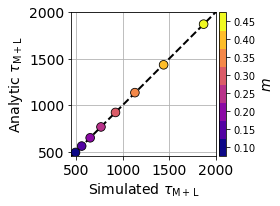

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4, 4))

# Plot
ax.plot([results[:,1].min()-50, 2000+50], [results[:,1].min()-50, 2000+50],
         'r--', label='Bisettrice', color="black", lw=2)
ax.grid(True)
ax.set_aspect('equal', adjustable='box')

sc = ax.scatter(results[:,1], results[:,2], c=results[:,0],
                cmap='plasma', edgecolor='black', zorder=3, lw=0.8, s=75)

# Colorbar with adjusted size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # size=5% of the main plot
# Discretize the colorbar
bounds = np.linspace(results[:, 0].min() - 0.025, results[:, 0].max() + 0.025, 9)  # Adjust bounds to center ticks
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256, extend='both')  # Create a norm for the bounds
cb = plt.colorbar(sc, cax=cax, boundaries=bounds, norm=norm)  # Apply the norm and bounds to the colorbar
cb.set_label('$m$', fontsize=14)
cb.set_ticks(results[:, 0].astype(float))
cb.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Labels and legend
#ax.set_title(fr'$\beta={beta_target}, \, N={N}$', fontsize=14)
ax.set_ylabel(r'Analytic $\tau_\mathrm{M+L}$', fontsize=14)
ax.set_xlabel(r'Simulated $\tau_\mathrm{M+L}$', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticks([500, 1000, 1500, 2000])
ax.set_yticks([500, 1000, 1500, 2000])
ax.set_xlim(450, 2000)
ax.set_ylim(450, 2000)
#ax.legend(fontsize=16)
plt.savefig(f"../Plots/FPS_MADE_N{N}_beta{beta_target}.pdf", bbox_inches='tight')
plt.tight_layout()


# Perfectly trained machine

In [32]:
def get_beta(m):
    return np.arctanh(m)/m

In [34]:

all_results = []
Ns = [20,50,100, 200, 350, 500, 700]
steps = [2, 2, 2, 4, 6, 8, 16]

#Ns = [20, 200]
#steps = [2,8]

for i, N in enumerate(Ns):
    beta = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    probMADE = compute_Pm_abs(N, W)

    results = []
    for M in np.arange(2,int(0.9*N),steps[i]):
        mtarget = M/float(N)
        beta_target = get_beta(mtarget)
        nmax = int((M+1)/2)

        P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, W, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #cumulative = probMADE[nmax:].sum()
        #fpt_made = 1/cumulative

        print(beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

1.0033534773107557 0.1 1.0654479992479606 2.125285131967 1.9947337959873388
1.0136627702704109 0.2 1.2226386710022312 2.4240434255605825 1.9826327132066959
1.0317320140103725 0.3 1.436565291918808 2.8062216174603773 1.9534243471190444
1.0591223254840045 0.4 1.741444014422888 3.301883731904581 1.8960608004379749
1.0986122886681096 0.5 2.2054220223021574 3.951104475508877 1.7915412268280821
1.1552453009332422 0.6 2.9747081359371768 4.790009343756266 1.6102451483856857
1.2390007538486474 0.7 4.408553262061552 5.7907272143640665 1.3135209829939027
1.373265360835137 0.8 7.57853576154271 6.705501257151342 0.8848016910045364
1.0005338459192052 0.04 1.0368047994194487 2.064306452088459 1.991027099068554
1.0021415629698711 0.08 1.1100143907833981 2.205354470223302 1.9867800710825578
1.0048419034037004 0.12 1.1939150455140897 2.3651868087765315 1.981034427586179
1.0086668508220347 0.16 1.2912548129717207 2.547183979856713 1.9726423896105918
1.0136627702704109 0.2 1.405691779915265 2.755911057468

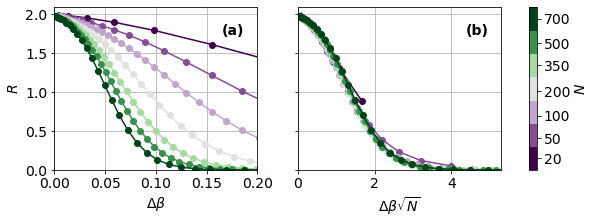

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create the custom discrete colormap from your existing custom_cmap.
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap using len(Ns) colors.
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (midpoints between successive Ns values).
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a 1 x 2 figure.
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Loop over each result set and plot in both subplots.
for i, results in enumerate(all_results):
    results = np.array(results)
    # Left subplot: original x-axis (Δβ)
    axs[0].plot(results[:, 0]-1, results[:, -1],
                marker="o", alpha=1, color=discrete_colors[i])
    # Right subplot: x-axis scaled by √N
    axs[1].plot((results[:, 0]-1) * np.sqrt(Ns[i]), results[:, -1],
                marker="o", alpha=1, color=discrete_colors[i])

# Formatting for the left subplot.
axs[0].set_xlabel(r'$\Delta \beta$', fontsize=14)
axs[0].set_ylabel(r'$R$', fontsize=14)
axs[0].tick_params(labelsize=14)
axs[0].grid(True)
axs[0].set_xlim(0, 0.20)
axs[0].set_ylim(0, None)

# Formatting for the right subplot.
axs[1].set_xlabel(r'$\Delta \beta \sqrt{N}$', fontsize=14)
#axs[1].set_ylabel(r'$R$', fontsize=14)
axs[1].tick_params(labelsize=14)
axs[1].grid(True)
axs[1].set_xlim(0, 0.20 * np.sqrt(max(Ns)))
axs[1].set_ylim(0, None)

axs[0].text(0.825, 0.9, "(a)", transform=axs[0].transAxes, fontsize=14, verticalalignment='top', fontweight='bold')
axs[1].text(0.825, 0.9, "(b)", transform=axs[1].transAxes, fontsize=14, verticalalignment='top', fontweight='bold')

# Add a common discretized colorbar.
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

#plt.tight_layout()
plt.savefig(f"../Plots/FPS_diffDB.pdf", bbox_inches='tight')
plt.show()

# Imperfectly trained machine

## Simulations

In [62]:
def montecarlo_CW(N, beta, pop_size, num_sweeps):
    # Population of spins, randomly initialized to -1 or 1
    pop = 2.*torch.randint(0, 2, (pop_size, N), device="cuda") - 1.

    
    # Loop to update the population using the Monte Carlo method
    for i in range(0, num_sweeps):  # Maximum number of iterations
        for n in range(N):
            # Perform a Monte Carlo update for the entire population
            pop = monte_carlo_update_CW(pop, N, beta)
        # Perform a Monte Carlo update for the entire population
        pop = monte_carlo_update_CW(pop, N, beta)  
    return pop

In [114]:
#function to perform GD and saving the weights at certain epochs

def train_different_epochs(dataset, input_size, optimal, epochs_save, start = "optimal", pert_type = "uniform_small", epochs=1, optimizer = "SGD", batch_size=256, learning_rate = 0.001):
    """
    Train the MADE architecture using data.

    Parameters:
    - data: Training data as a PyTorch tensor, aka #configurations x #spins tensor.
    - input_size (int): Size of the input features.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for optimization.

    Returns:
    - model: Trained MADE model.
    """
    data = torch.clone(dataset)
    model = made(input_size)
    model = model.to(device)
    # Set model.layer.weights to optimal, then add a small Gaussian perturbation
    with torch.no_grad():
        if start == "optimal":
            model.layer.weight = nn.Parameter(optimal.clone())
        elif start == "random":
            pass # layers are already initialized randomly 
        elif start == "zero":
            model.layer.weight = nn.Parameter(torch.zeros_like(model.layer.weight))
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'zero', 'optimal' and 'random'")
        if pert_type == "uniform_small":
            perturbation = 0.01
        elif pert_type == "uniform_large":
            perturbation = 0.3
        elif pert_type == "none":
            perturbation = 0
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'uniform_small', 'uniform_large' and 'none'")
        model.layer.weight += perturbation
    model.train()
    clipper = AutoregressiveMasking()
    model.apply(clipper)

    weights = []

    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer}' is not supported. Supported optimizers are 'SGD' and 'Adam'")
    criterion = nn.BCELoss(reduction="mean")
    for epoch in tqdm(range(epochs)):
        tot_loss = 0
        count = 0
        if epoch in epochs_save:
            with torch.no_grad():
                res = model.layer.weight.sum(1)
                res[1:]/= torch.arange(1, len(res), device = "cuda")
                weights.append(res.cpu().numpy())
        for i in range(0, len(data), batch_size):
            indices = random.sample(range(data.shape[0]), batch_size)
            #batch_data = data[indices]
            batch_data = data[indices].to(device)

            # Forward pass
            output = model(batch_data)

            # Compute loss
            loss = criterion(output, (batch_data + 1) / 2)
            tot_loss += loss
            count += 1

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.apply(clipper)
    
    return model, weights

In [155]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]

times = np.arange(0,1001, 25)

num_epochs = 1001
for i, N in enumerate(Ns):
    results = []
    lr = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta
    model_exact = setup_model(W, N = N)

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)
    pop = montecarlo_CW(N, beta, pop_size, num_sweeps)
    model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "zero", pert_type="none", epochs = num_epochs, learning_rate=lr, batch_size=pop_size)

    for count, Wpert in enumerate(weights):

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

100%|██████████| 1001/1001 [00:39<00:00, 25.45it/s]


0 1.1118033988749896 0.5267722209710917 24.160737327188922 5.932665202009426 0.24554984070511748
25 1.1118033988749896 0.5267722209710917 2.4633012893344035 4.094967309504979 1.6623899509310367
50 1.1118033988749896 0.5267722209710917 2.2380990130286516 3.9298559459313176 1.755890120613269
75 1.1118033988749896 0.5267722209710917 2.2046975965909033 3.903327282766 1.7704592633482554
100 1.1118033988749896 0.5267722209710917 2.1978935138101594 3.8978627643057946 1.7734538729079066
125 1.1118033988749896 0.5267722209710917 2.1963246367420144 3.8966001839840905 1.774145824710245
150 1.1118033988749896 0.5267722209710917 2.195936926002258 3.8962880372155233 1.7743169173391444
175 1.1118033988749896 0.5267722209710917 2.195836368876553 3.896207062122138 1.7743612945601857
200 1.1118033988749896 0.5267722209710917 2.195809856956403 3.8961856311683962 1.7743729580342047
225 1.1118033988749896 0.5267722209710917 2.1958021693377736 3.896179480185617 1.7743763689607137
250 1.1118033988749896 0.52

100%|██████████| 1001/1001 [00:38<00:00, 25.73it/s]


0 1.0707106781186548 0.43321638618915215 151.5048722326576 8.437019614583305 0.05568810751925551
25 1.0707106781186548 0.43321638618915215 4.020096324448288 5.474601042166544 1.3618084245575557
50 1.0707106781186548 0.43321638618915215 2.895235959419154 4.75043391108425 1.6407760810062915
75 1.0707106781186548 0.43321638618915215 2.641953534635659 4.5333148512676615 1.7158949965760215
100 1.0707106781186548 0.43321638618915215 2.5508545321695406 4.448857281088976 1.7440654592346179
125 1.0707106781186548 0.43321638618915215 2.5116878196771495 4.411457551788176 1.7563717581571188
150 1.0707106781186548 0.43321638618915215 2.493256431812578 4.393631149078036 1.762205881841003
175 1.0707106781186548 0.43321638618915215 2.4841018170838 4.384723936301517 1.7651144192829198
200 1.0707106781186548 0.43321638618915215 2.47938775188426 4.3801236320777726 1.7666150156420715
225 1.0707106781186548 0.43321638618915215 2.476895796786805 4.37768804090202 1.7674090474783193
250 1.0707106781186548 0.4

100%|██████████| 1001/1001 [00:38<00:00, 25.82it/s]


0 1.05 0.37070573256992784 2446.3206879697577 12.300995560423868 0.00502836591331477
25 1.05 0.37070573256992784 9.850579003686828 8.48095735729716 0.8609602901639536
50 1.05 0.37070573256992784 4.773939959323338 6.615456202831816 1.3857434863444527
75 1.05 0.37070573256992784 3.761111472110303 5.901896345917061 1.5691894243713005
100 1.05 0.37070573256992784 3.3715967255719836 5.564884167248132 1.6505189143888679
125 1.05 0.37070573256992784 3.1791969668835067 5.382291878423159 1.692972135570227
150 1.05 0.37070573256992784 3.0713511816783674 5.274793265237417 1.7174178246705603
175 1.05 0.37070573256992784 3.006248627876429 5.208019627648958 1.7323981720460122
200 1.05 0.37070573256992784 2.9650196844048025 5.164981252103871 1.741971994071496
225 1.05 0.37070573256992784 2.938026382445039 5.136483416909333 1.7482768186154707
250 1.05 0.37070573256992784 2.919918145804721 5.117222976788625 1.7525227493588977
275 1.05 0.37070573256992784 2.9075421753424537 5.103993235315535 1.755432226

100%|██████████| 1001/1001 [00:38<00:00, 26.12it/s]


0 1.0353553390593273 0.3156711724359867 72163.34361179074 16.635544419719395 0.00023052624209337938
25 1.0353553390593273 0.3156711724359867 42.6134814964072 13.224712409220345 0.3103410457166082
50 1.0353553390593273 0.3156711724359867 10.751709224938743 9.972664837089528 0.9275422752279973
75 1.0353553390593273 0.3156711724359867 6.529910184221194 8.285855011895261 1.2689079601610929
100 1.0353553390593273 0.3156711724359867 5.108025222219769 7.382636950990692 1.4453015852146587
125 1.0353553390593273 0.3156711724359867 4.4290753599653065 6.846297165023174 1.5457621757595927
150 1.0353553390593273 0.3156711724359867 4.042377798245367 6.501008564716675 1.6082139990820503
175 1.0353553390593273 0.3156711724359867 3.7981217416893776 6.265549789676908 1.6496442757229883
200 1.0353553390593273 0.3156711724359867 3.63318003951147 6.098184895498884 1.678470328797377
225 1.0353553390593273 0.3156711724359867 3.516542441013364 5.97549809057037 1.6992537956824452
250 1.0353553390593273 0.31567

100%|██████████| 1001/1001 [00:38<00:00, 26.14it/s]


0 1.0267261241912424 0.27652547186691834 3083744.5423675235 21.259228284953448 6.893965434838459e-06
25 1.0267261241912424 0.27652547186691834 308.36304557014927 18.674394417718513 0.060559767734782895
50 1.0267261241912424 0.27652547186691834 33.892481712640624 14.94572359036539 0.44097460071185035
75 1.0267261241912424 0.27652547186691834 14.3489980932407 12.152744697753562 0.8469402963736044
100 1.0267261241912424 0.27652547186691834 9.27144857568801 10.396947476062449 1.1213940724781422
125 1.0267261241912424 0.27652547186691834 7.149912429373892 9.274564924755254 1.297157834640419
150 1.0267261241912424 0.27652547186691834 6.027032373957802 8.5188258329486 1.4134362160982554
175 1.0267261241912424 0.27652547186691834 5.344961194229377 7.98450136079696 1.4938371057618398
200 1.0267261241912424 0.27652547186691834 4.892344394456345 7.5914189737122655 1.551693495313682
225 1.0267261241912424 0.27652547186691834 4.573179486338897 7.293002672148881 1.5947335314379636
250 1.026726124191

100%|██████████| 1001/1001 [00:39<00:00, 25.42it/s]


0 1.022360679774998 0.2539045057902792 52068715.258930154 24.60518286214032 4.725521407582715e-07
25 1.022360679774998 0.2539045057902792 1767.8908347404367 22.552394285267262 0.012756666781735097
50 1.022360679774998 0.2539045057902792 98.24271288317073 19.138667557833177 0.1948100474443605
75 1.022360679774998 0.2539045057902792 29.968009339501492 15.871255218454007 0.5296065894351466
100 1.022360679774998 0.2539045057902792 16.191615605870012 13.465186887905025 0.8316147823459591
125 1.022360679774998 0.2539045057902792 11.186536154371032 11.798526279994789 1.0547077412684738
150 1.022360679774998 0.2539045057902792 8.756976252098847 10.628628102535046 1.2137326625714677
175 1.022360679774998 0.2539045057902792 7.362617675524148 9.781155353859152 1.3284888316793968
200 1.022360679774998 0.2539045057902792 6.4720996103554445 9.14723174818018 1.4133329674877824
225 1.022360679774998 0.2539045057902792 5.860243071913276 8.659478423871326 1.4776654001561993
250 1.022360679774998 0.25390

100%|██████████| 1001/1001 [00:38<00:00, 25.77it/s]


0 1.0188982236504613 0.2341322682996002 1015351781.9843501 28.021846225263356 2.7598165209794516e-08
25 1.0188982236504613 0.2341322682996002 13807.074017753317 26.39534752510746 0.0019117263723775202
50 1.0188982236504613 0.2341322682996002 366.2703242131384 23.53846305990061 0.06426527486350003
75 1.0188982236504613 0.2341322682996002 75.48938054818677 20.25485633163318 0.2683139825038569
100 1.0188982236504613 0.2341322682996002 32.64691265154281 17.382237014564282 0.5324312654030653
125 1.0188982236504613 0.2341322682996002 19.635805336152917 15.160782846894776 0.7720988565200914
150 1.0188982236504613 0.2341322682996002 14.00092365667492 13.499170506185303 0.9641628536235604
175 1.0188982236504613 0.2341322682996002 11.00915934382759 12.25019630517094 1.1127276772535
200 1.0188982236504613 0.2341322682996002 9.201600511615503 11.294490846927557 1.22744851101394
225 1.0188982236504613 0.2341322682996002 8.009209581713536 10.54794880874987 1.3169774996065444
250 1.0188982236504613 0

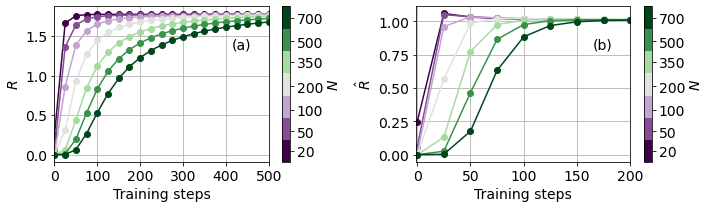

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assumed pre-defined variables: ptog, all_results, data, coeff, and Ns.
Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a custom discrete colormap from the provided ptog colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (boundaries halfway between successive Ns values)
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a 1x2 figure; note that we are not sharing the y-axis.
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax1, ax2 = axes

# ---------------------------
# Left subplot (first plot)
# ---------------------------
for i, results in enumerate(all_results):
    results = np.array(results)
    ax1.plot(results[:, 0], results[:, -1],
             marker="o", alpha=1,
             color=discrete_colors[i],
             label=f'N={Ns[i]}')

ax1.set_xlabel(r'Training steps', fontsize=14)
ax1.set_ylabel(r'$R$', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True)
ax1.set_xlim(0, 500)
# If desired, you can uncomment the following line to add a legend:
# ax1.legend(fontsize=14)

# Add the discretized colorbar to the left subplot
cbar = fig.colorbar(sm, ax=ax2, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

cbar = fig.colorbar(sm, ax=ax1, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ---------------------------
# Right subplot (second plot)
# ---------------------------
# Loop over your data and plot each with the corresponding color
for i, d in enumerate(np.array(all_results)):
    ax2.plot(d[:, 0],
             (d[:, 0] + d[:, 4]) / (d[:, 0] + d[:, 3]),
             marker="o", color=discrete_colors[i],
             label=f'N={Ns[i]}')

ax2.set_xlabel(r'Training steps', fontsize=14)
ax2.set_ylabel(r'$\hat{R}$', fontsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xlim(-1, 200)
ax2.grid(True)
#ax2.legend(loc='best', fontsize=14)

# Add text labels to the subplots
ax1.text(0.825, 0.80, "(a)", transform=ax1.transAxes, fontsize=14, verticalalignment='top')
ax2.text(0.825, 0.80, "(b)", transform=ax2.transAxes, fontsize=14, verticalalignment='top')

plt.tight_layout()
plt.savefig(f"../Plots/R_vs_trainingtime_simulated.pdf", bbox_inches='tight')
plt.show()


## Analytical

In [34]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 0.5
Ns = [20, 50, 100, 200, 350, 500, 700]

cvalues = [0.210102, 0.143354, 0.105536, 0.0768534, 0.0591336, 0.0499253, 0.0425013]

times = np.concatenate((np.arange(0, 50, 5), np.arange(50, 100, 10), np.arange(100, 1001, 25)))  # training times
num_epochs = len(times)  # 1001 or as needed

for i, N in enumerate(Ns):
    results = []
    
    # Load the couplings from file and setup the exact model.
    W = np.concatenate([np.array([0]), np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")])
    W *= beta
    model_exact = setup_model(W, N=N)
    
    beta_target = 1 + coeff / np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int(mtarget * N / 2)
    
    # Compute the analytical weights for all times 
    analytical_weights = weights_analytical(torch.tensor(times), cvalues[i], N)
    
    # Loop over each training time weight vector.
    for count, Wpert in enumerate(analytical_weights):
        # Compute result for k=1:
        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device) - P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv,
                              torch.ones(P_inv.shape[0],
                                         device=P_inv.device,
                                         dtype=P_inv.dtype))
        
        # Compute result for k=0:
        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device) - P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv,
                                torch.ones(P_inv.shape[0],
                                           device=P_inv.device,
                                           dtype=P_inv.dtype))[0]
        
        # Print and store the outputs.
        print(times[count], beta_target, mtarget, fpt_made.item(),
              result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((times[count], beta_target, mtarget, fpt_made.item(),
                        result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    
    all_results.append(results)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


0 1.1118033988749896 0.5267722209710917 24.160737327188922 5.932665202009426 0.24554984070511748
5 1.1118033988749896 0.5267722209710917 6.028050582769527 5.215364843552558 0.865182660951795
10 1.1118033988749896 0.5267722209710917 3.849040117274254 4.745651414207548 1.2329441288256149
15 1.1118033988749896 0.5267722209710917 3.1820598394324673 4.49255516128376 1.4118386793395514
20 1.1118033988749896 0.5267722209710917 2.8939197871287816 4.353309590347428 1.504295181127528
25 1.1118033988749896 0.5267722209710917 2.746008045919824 4.272712070527422 1.5559721599782137
30 1.1118033988749896 0.5267722209710917 2.661938000769356 4.223802476125848 1.586739614110126
35 1.1118033988749896 0.5267722209710917 2.610880962515167 4.192946245123721 1.6059507519961718
40 1.1118033988749896 0.5267722209710917 2.5784199816715265 4.172867873513085 1.6183817621549446
45 1.1118033988749896 0.5267722209710917 2.557086011135782 4.15947718992428 1.626647352420016
50 1.1118033988749896 0.5267722209710917 2.

100 1.1118033988749896 0.5267722209710917 2.5097761967549 4.129247395064079 1.6452651835662195
125 1.1118033988749896 0.5267722209710917 2.5085793166428387 4.12847387399249 1.6457418135446924
150 1.1118033988749896 0.5267722209710917 2.508289528433913 4.128286551054121 1.6458572681725767
175 1.1118033988749896 0.5267722209710917 2.508215303355832 4.128238590019928 1.6458868520962329
200 1.1118033988749896 0.5267722209710917 2.5081959743852362 4.128226108523046 1.6458945595488736
225 1.1118033988749896 0.5267722209710917 2.508191046980852 4.128222915372631 1.645896519861131
250 1.1118033988749896 0.5267722209710917 2.5081892424190473 4.128221758290648 1.645897242709304
275 1.1118033988749896 0.5267722209710917 2.5081889494709477 4.128221574927699 1.6458973618388937
300 1.1118033988749896 0.5267722209710917 2.5081889260351025 4.128221565209035 1.645897373342944
325 1.1118033988749896 0.5267722209710917 2.5081889260351025 4.128221565209035 1.645897373342944
350 1.1118033988749896 0.526772

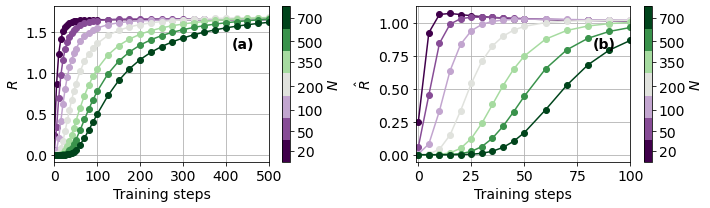

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assumed pre-defined variables: ptog, all_results, data, coeff, and Ns.
Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a custom discrete colormap from the provided ptog colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (boundaries halfway between successive Ns values)
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a 1x2 figure; note that we are not sharing the y-axis.
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax1, ax2 = axes

# ---------------------------
# Left subplot (first plot)
# ---------------------------
for i, results in enumerate(all_results):
    results = np.array(results)
    ax1.plot(results[:, 0], results[:, -1],
             marker="o", alpha=1,
             color=discrete_colors[i],
             label=f'N={Ns[i]}')

ax1.set_xlabel(r'Training steps', fontsize=14)
ax1.set_ylabel(r'$R$', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True)
ax1.set_xlim(0, 500)
# If desired, you can uncomment the following line to add a legend:
# ax1.legend(fontsize=14)

# Add the discretized colorbar to the left subplot
cbar = fig.colorbar(sm, ax=ax2, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

cbar = fig.colorbar(sm, ax=ax1, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ---------------------------
# Right subplot (second plot)
# ---------------------------
# Loop over your data and plot each with the corresponding color
for i, d in enumerate(np.array(all_results)):
    ax2.plot(d[:, 0],
             (d[:, 0] + d[:, 4]) / (d[:, 0] + d[:, 3]),
             marker="o", color=discrete_colors[i],
             label=f'N={Ns[i]}')

ax2.set_xlabel(r'Training steps', fontsize=14)
ax2.set_ylabel(r'$\hat{R}$', fontsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xlim(-1, 100)
ax2.grid(True)
#ax2.legend(loc='best', fontsize=14)

# Add text labels to the subplots
ax1.text(0.825, 0.80, "(a)", transform=ax1.transAxes, fontsize=14, verticalalignment='top', fontweight='bold')
ax2.text(0.825, 0.80, "(b)", transform=ax2.transAxes, fontsize=14, verticalalignment='top', fontweight='bold')

plt.tight_layout()
plt.savefig(f"../Plots/R_vs_trainingtime.pdf", bbox_inches='tight')
plt.show()

# Comparison with vanilla MC

In [13]:
def transition_matrix_local_signed(N, beta):
    """Get the transition matrix for the system in magnetizations."""
    P = torch.zeros((N+1, N+1))

    for i in range(0, N+1):
        m = (2*i-N)/N
        
        if i != 0:
            P[i, i-1] = (1+m)/2*min(1, np.exp(-2*beta*(m-1/N)))
        P[i, i] = 1 - (1+m)/2*min(1, np.exp(-2*beta*(m-1/N))) - (1-m)/2*min(1, np.exp(2*beta*(m+1/N)))
        if i != N:
            P[i, i+1] = (1-m)/2*min(1, np.exp(2*beta*(m+1/N)))
    return P.to(device)

In [14]:
def transition_matrix_global_signed(probMADE, beta, N):
    device = probMADE.device
    # Define the full state space for signed magnetization:
    # S values go from -N to N in steps of 2, so normalized m = S/N
    states = torch.arange(-N, N+1, step=2, dtype=torch.float64, device=device)
    M = len(states)
    
    # Compute normalized magnetization values and their squares
    m_vals = states / N
    m2 = m_vals ** 2

    # Compute configuration counts (degeneracies)
    # For each state with magnetization S, k = (N + S) / 2 must be an integer.
    k = (N + states) / 2  # k values for the binomial coefficient
    N_tensor = torch.tensor(N, dtype=torch.float64, device=device)
    config = torch.exp(torch.lgamma(N_tensor + 1) - torch.lgamma(k + 1) - torch.lgamma(N_tensor - k + 1))
    
    # Compute the exponent matrix for all (i, j):
    # exponent[i,j] = 0.5 * beta * N * (m_vals[j]^2 - m_vals[i]^2)
    exponent_matrix = 0.5 * beta * N * (m2[None, :] - m2[:, None])
    exp_matrix = torch.exp(exponent_matrix)
    
    # Compute the ratio matrix (for all i, j):
    # ratio[i,j] = exp_matrix[i,j] * (probMADE[i]*config[j])/(probMADE[j]*config[i])
    ratio = exp_matrix * ((probMADE[:, None] * config[None, :]) / (probMADE[None, :] * config[:, None]))
    
    # Acceptance probability: elementwise, alpha[i,j] = min(1, ratio[i,j])
    ones = torch.ones_like(ratio)
    alpha = torch.minimum(ones, ratio)
    
    # Off-diagonals: set T[i,j] = probMADE[j] * alpha[i,j]
    T = probMADE[None, :] * alpha
    
    # Now zero out the diagonal and set T[i,i] = 1 - sum_{j != i} T[i,j]
    T.fill_diagonal_(0)
    diag = 1 - T.sum(dim=1)
    T.diagonal(dim1=0, dim2=1).copy_(diag)
    
    return T

def get_matrix_mixed_signed(N, beta_target, W, k):
    probMADE = compute_Pm(torch.tensor(W, dtype=torch.float32).to(device))[::2]
    Tmade = transition_matrix_global_signed(probMADE, beta_target, N).float()
    Tlocal = transition_matrix_local_signed(N, beta_target).float()
    T = torch.matmul(Tmade, torch.matrix_power(Tlocal, N * k).to(device))
    return T

## Starting from $0$

In [28]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 2
Ns = [20, 50, 100, 200, 350, 500, 700]

cvalues = [0.210102, 0.143354, 0.105536, 0.0768534, 0.0591336, 0.0499253, 0.0425013]

times = np.arange(10, 1001, 25)  # training times
num_epochs = len(times)  # 1001 or as needed

for i, N in enumerate(Ns):
    results = []
    
    # Load the couplings from file and setup the exact model.
    W = np.concatenate([np.array([0]), np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")])
    W *= beta
    model_exact = setup_model(W, N=N)
    
    beta_target = 1 + coeff / np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int(N/2+mtarget * N / 2)
    
    # Compute the analytical weights for all times 
    analytical_weights = weights_analytical(torch.tensor(times), cvalues[i], N)
    
    # Loop over each training time weight vector.
            # Compute result for local MCMC:
    P = transition_matrix_local_signed(N, beta_target)
    P = torch.matrix_power(P, N)[:nmax, :nmax]
    P = torch.eye(P.shape[0]).to(device) - P
    P_inv = torch.linalg.inv(P)
    fpt_MC = torch.matmul(P_inv,
                            torch.ones(P_inv.shape[0],
                                        device=P_inv.device,
                                        dtype=P_inv.dtype))[int(N/2)]
    for count, Wpert in enumerate(analytical_weights):
        # Compute result for k=1:
        P = get_matrix_mixed_signed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device) - P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv,
                              torch.ones(P_inv.shape[0],
                                         device=P_inv.device,
                                         dtype=P_inv.dtype))[int(N/2)]
        
        # Print and store the outputs.
        print(times[count], beta_target, mtarget, fpt_MC.item(),
              result.item() * 2, (result.item() * 2) / fpt_MC.item())
        results.append((times[count], beta_target, mtarget, fpt_MC.item(),
                        result.item() * 2, (result.item() * 2) / fpt_MC.item()))
    
    all_results.append(results)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


10 1.4472135954999579 0.8371311400956193 42.95646667480469 25.848453521728516 0.6017360253907811
35 1.4472135954999579 0.8371311400956193 42.95646667480469 21.468231201171875 0.499767156449198
60 1.4472135954999579 0.8371311400956193 42.95646667480469 20.597366333007812 0.479493960453894
85 1.4472135954999579 0.8371311400956193 42.95646667480469 20.231046676635742 0.4709662652143102
110 1.4472135954999579 0.8371311400956193 42.95646667480469 20.03497886657715 0.46640192775278444
135 1.4472135954999579 0.8371311400956193 42.95646667480469 19.916383743286133 0.46364110656633023
160 1.4472135954999579 0.8371311400956193 42.95646667480469 19.839229583740234 0.4618450054081511
185 1.4472135954999579 0.8371311400956193 42.95646667480469 19.786623001098633 0.4606203566715627
210 1.4472135954999579 0.8371311400956193 42.95646667480469 19.74959373474121 0.4597583382323427
235 1.4472135954999579 0.8371311400956193 42.95646667480469 19.722972869873047 0.4591386209481048
260 1.4472135954999579 0.8

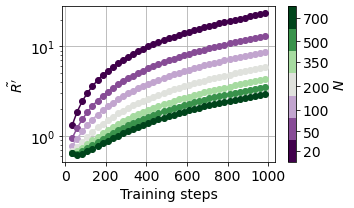

In [29]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

plt.figure(figsize=(5, 3))

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap from your existing custom_cmap using len(Ns) colors
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar.
# We set boundaries midway between successive Ns values.
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Plot each result using its corresponding discrete color.
for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot(results[1:, 0], (results[1:, -2]+results[1:, 0])/results[1:, -3],
             marker="o", alpha=1,
             color=discrete_colors[i])

plt.xlabel(r'Training steps', fontsize=14)
plt.ylabel(r"$\tilde{R'}$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.xlim(0, 0.20)
#plt.ylim(0, None)
plt.yscale("log")

# Add the discretized colorbar with ticks at each N.
cbar = plt.colorbar(sm, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(f"../Plots/FPS_comparison_vanilla.pdf", bbox_inches='tight')
plt.show()

In [30]:
all_results2 = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 2
Ns = [20, 50, 100, 200, 350, 500, 700]

cvalues = [0.210102, 0.143354, 0.105536, 0.0768534, 0.0591336, 0.0499253, 0.0425013]

times = np.arange(10, 1001, 25)  # training times
num_epochs = len(times)  # 1001 or as needed

for i, N in enumerate(Ns):
    results = []
    
    # Load the couplings from file and setup the exact model.
    W = np.concatenate([np.array([0]), np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")])
    W *= beta
    model_exact = setup_model(W, N=N)
    
    beta_target = 1 + coeff / np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int(mtarget * N / 2)
    
    # Compute the analytical weights for all times 
    analytical_weights = weights_analytical(torch.tensor(times), cvalues[i], N)
    
    # Loop over each training time weight vector.
            # Compute result for local MCMC:
    P = transition_matrix_local(N, beta_target)
    P = torch.matrix_power(P, N)[:nmax, :nmax]
    P = torch.eye(P.shape[0]).to(device) - P
    P_inv = torch.linalg.inv(P)
    fpt_MC = torch.matmul(P_inv,
                            torch.ones(P_inv.shape[0],
                                        device=P_inv.device,
                                        dtype=P_inv.dtype))[0]
    for count, Wpert in enumerate(analytical_weights):
        # Compute result for k=1:
        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device) - P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv,
                              torch.ones(P_inv.shape[0],
                                         device=P_inv.device,
                                         dtype=P_inv.dtype))[0]
        
        # Print and store the outputs.
        print(times[count], beta_target, mtarget, fpt_MC.item(),
              result.item() * 2, (result.item() * 2) / fpt_MC.item())
        results.append((times[count], beta_target, mtarget, fpt_MC.item(),
                        result.item() * 2, (result.item() * 2) / fpt_MC.item()))
    
    all_results2.append(results)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


10 1.4472135954999579 0.8371311400956193 4.993366601334063 7.291374669126455 1.4602121677143511
35 1.4472135954999579 0.8371311400956193 4.993366601334063 6.764273942956784 1.35465197791598
60 1.4472135954999579 0.8371311400956193 4.993366601334063 6.6414129590061535 1.3300471383839083
85 1.4472135954999579 0.8371311400956193 4.993366601334063 6.587424650665254 1.319235132646842
110 1.4472135954999579 0.8371311400956193 4.993366601334063 6.557903233857089 1.3133230057863232
135 1.4472135954999579 0.8371311400956193 4.993366601334063 6.539822548863591 1.3097020649588127
160 1.4472135954999579 0.8371311400956193 4.993366601334063 6.5279668193052185 1.3073277691169642
185 1.4472135954999579 0.8371311400956193 4.993366601334063 6.519840362630012 1.3057003186764065
210 1.4472135954999579 0.8371311400956193 4.993366601334063 6.514099918302591 1.304550704641281
235 1.4472135954999579 0.8371311400956193 4.993366601334063 6.509960674547783 1.3037217561411445
260 1.4472135954999579 0.83713114009

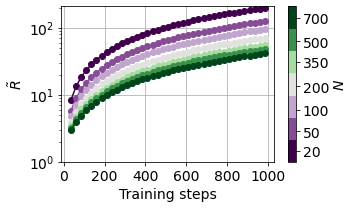

In [31]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

plt.figure(figsize=(5, 3))

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap from your existing custom_cmap using len(Ns) colors
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar.
# We set boundaries midway between successive Ns values.
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Plot each result using its corresponding discrete color.
for i, results in enumerate(all_results2):
    results = np.array(results)
    plt.plot(results[1:, 0], (results[1:, -2]+results[1:, 0])/results[1:, -3],
             marker="o", alpha=1,
             color=discrete_colors[i])

plt.xlabel(r'Training steps', fontsize=14)
plt.ylabel(r'$\tilde{R}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.xlim(0, 0.20)
plt.ylim(1, None)
plt.yscale("log")

# Add the discretized colorbar with ticks at each N.
cbar = plt.colorbar(sm, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig(f"../Plots/FPS_comparison_vanilla.pdf", bbox_inches='tight')
plt.show()

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


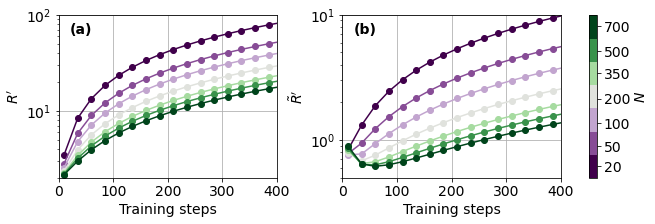

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create discrete colormap
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create norm for colorbar
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a gridspec to allow space for colorbar on the right
fig, axs = plt.subplots(1, 2, figsize=(10, 3),
                        gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3})

# Plot first dataset on left subplot (all_results2)
for i, results in enumerate(all_results2):
    results = np.array(results)
    axs[0].plot(results[:, 0], (results[:, -2] + results[:, 0]) / results[:, -3],
                marker="o", alpha=1, color=discrete_colors[i])
axs[0].set_xlabel(r'Training steps', fontsize=14)
axs[0].set_ylabel(r"$R'$", fontsize=14)
axs[0].set_yscale("log")
axs[0].set_ylim(1, None)
axs[0].set_xlim(0, 400)
axs[0].set_ylim(2, 100)
axs[0].grid(True)
axs[0].tick_params(axis='both', labelsize=14)

# Plot second dataset on right subplot (all_results)
for i, results in enumerate(all_results):
    results = np.array(results)
    axs[1].plot(results[:, 0], (results[:, -2] + results[:, 0]) / results[:, -3],
                marker="o", alpha=1, color=discrete_colors[i])
axs[1].set_xlabel(r'Training steps', fontsize=14)
axs[1].set_ylabel(r"$\tilde{R}'$", fontsize=14)
axs[1].set_yscale("log")
axs[1].grid(True)
axs[1].set_ylim(0.5, None)
axs[1].set_xlim(0, 400)
axs[1].set_ylim(0.5, 10)
axs[1].tick_params(axis='both', labelsize=14)

axs[0].text(0.05, 0.95, "(a)", transform=axs[0].transAxes, fontsize=14, verticalalignment='top', fontweight='bold')
axs[1].text(0.05, 0.95, "(b)", transform=axs[1].transAxes, fontsize=14, verticalalignment='top', fontweight='bold')

# Add the colorbar on the right, spanning both subplots
cbar = fig.colorbar(sm, ax=axs, boundaries=boundaries, ticks=Ns, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(f"../Plots/FPS_comparison_vanilla_both.pdf", bbox_inches='tight')
plt.show()


## Starting from $-m^*$

In [28]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 2
Ns = [20, 50, 100, 200, 350, 500, 700]

cvalues = [0.210102, 0.143354, 0.105536, 0.0768534, 0.0591336, 0.0499253, 0.0425013]

times = np.arange(0, 1001, 25)  # training times
num_epochs = len(times)  # 1001 or as needed

for i, N in enumerate(Ns):
    results = []
    
    # Load the couplings from file and setup the exact model.
    W = np.concatenate([np.array([0]), np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")])
    W *= beta
    model_exact = setup_model(W, N=N)
    
    beta_target = 1 + coeff / np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int(N/2+mtarget * N / 2)
    
    # Compute the analytical weights for all times 
    analytical_weights = weights_analytical(torch.tensor(times), cvalues[i], N)
    
    # Loop over each training time weight vector.
            # Compute result for local MCMC:
    P = transition_matrix_local_signed(N, beta_target)
    P = torch.matrix_power(P, N)[:nmax, :nmax]
    P = torch.eye(P.shape[0]).to(device) - P
    P_inv = torch.linalg.inv(P)
    fpt_MC = torch.matmul(P_inv,
                            torch.ones(P_inv.shape[0],
                                        device=P_inv.device,
                                        dtype=P_inv.dtype))[int(N/2-mtarget * N / 4)]
    for count, Wpert in enumerate(analytical_weights):
        # Compute result for k=1:
        P = get_matrix_mixed_signed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device) - P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv,
                              torch.ones(P_inv.shape[0],
                                         device=P_inv.device,
                                         dtype=P_inv.dtype))[int(N/2-mtarget * N / 4)]
        
        # Print and store the outputs.
        print(times[count], beta_target, mtarget, fpt_MC.item(),
              result.item() * 2, (result.item() * 2) / fpt_MC.item())
        results.append((times[count], beta_target, mtarget, fpt_MC.item(),
                        result.item() * 2, (result.item() * 2) / fpt_MC.item()))
    
    all_results.append(results)

/home/delbono/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 1.4472135954999579 0.8371311400956193 68.59809875488281 88.5692138671875 1.291132195713852
25 1.4472135954999579 0.8371311400956193 68.59809875488281 24.38558578491211 0.3554848636847438
50 1.4472135954999579 0.8371311400956193 68.59809875488281 22.58585548400879 0.3292490009776128
75 1.4472135954999579 0.8371311400956193 68.59809875488281 21.960872650146484 0.3201382115358308
100 1.4472135954999579 0.8371311400956193 68.59809875488281 21.651813507080078 0.31563285134836044
125 1.4472135954999579 0.8371311400956193 68.59809875488281 21.47272300720215 0.31302213030610737
150 1.4472135954999579 0.8371311400956193 68.59809875488281 21.359224319458008 0.3113675846291244
175 1.4472135954999579 0.8371311400956193 68.59809875488281 21.283170700073242 0.3102589005582069
200 1.4472135954999579 0.8371311400956193 68.59809875488281 21.230274200439453 0.30948779318651715
225 1.4472135954999579 0.8371311400956193 68.59809875488281 21.192537307739258 0.30893767746341183
250 1.4472135954999579 0.83

150 1.282842712474619 0.7387261394760112 125.8708724975586 34.98894119262695 0.27797488408849796
175 1.282842712474619 0.7387261394760112 125.8708724975586 34.66023635864258 0.2753634393001832
200 1.282842712474619 0.7387261394760112 125.8708724975586 34.413936614990234 0.27340667409497565
225 1.282842712474619 0.7387261394760112 125.8708724975586 34.22332763671875 0.27189235251692206
250 1.282842712474619 0.7387261394760112 125.8708724975586 34.07201385498047 0.27069021751351835
275 1.282842712474619 0.7387261394760112 125.8708724975586 33.9494514465332 0.2697165021017209
300 1.282842712474619 0.7387261394760112 125.8708724975586 33.84852981567383 0.26891471508891274
325 1.282842712474619 0.7387261394760112 125.8708724975586 33.76424789428711 0.2682451247403724
350 1.282842712474619 0.7387261394760112 125.8708724975586 33.693023681640625 0.26767927331475466
375 1.282842712474619 0.7387261394760112 125.8708724975586 33.63222885131836 0.26719627967916637
400 1.282842712474619 0.73872613

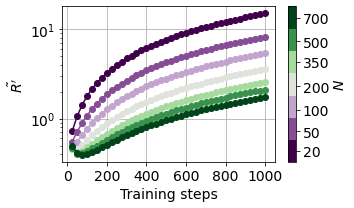

In [29]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

plt.figure(figsize=(5, 3))

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap from your existing custom_cmap using len(Ns) colors
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar.
# We set boundaries midway between successive Ns values.
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Plot each result using its corresponding discrete color.
for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot(results[1:, 0], (results[1:, -2]+results[1:, 0])/results[1:, -3],
             marker="o", alpha=1,
             color=discrete_colors[i])

plt.xlabel(r'Training steps', fontsize=14)
plt.ylabel(r"$\tilde{R'}$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.xlim(0, 0.20)
#plt.ylim(0, None)
plt.yscale("log")

# Add the discretized colorbar with ticks at each N.
cbar = plt.colorbar(sm, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig(f"../Plots/FPS_comparison_vanilla.pdf", bbox_inches='tight')
plt.show()